In [39]:
!pip install detecto

In [8]:
import torch
from detecto import core, utils, visualize
from detecto.visualize import show_labeled_image, plot_prediction_grid
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np

In [9]:
custom_transforms = transforms.Compose([
transforms.ToPILImage(),
transforms.Resize(900),
transforms.RandomHorizontalFlip(0.5),
transforms.ColorJitter(saturation=0.2),
transforms.ToTensor(),
utils.normalize_transform(),
])

In [10]:
Train_dataset=core.Dataset('/content/drive/MyDrive/train',transform=custom_transforms)#L1
Test_dataset = core.Dataset('/content/drive/MyDrive/test')#L2
loader=core.DataLoader(Train_dataset, batch_size=2, shuffle=True)#L3
model = core.Model(['vehicle'])#L4
losses = model.fit(loader, Test_dataset, epochs=1, lr_step_size=5, learning_rate=0.001, verbose=True)#L5

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


It looks like you're training your model on a CPU. Consider switching to a GPU; otherwise, this method can take hours upon hours or even days to finish. For more information, see https://detecto.readthedocs.io/en/latest/usage/quickstart.html#technical-requirements
Epoch 1 of 1
Begin iterating over training dataset


100%|██████████| 6/6 [06:15<00:00, 62.65s/it]


Begin iterating over validation dataset


100%|██████████| 11/11 [01:44<00:00,  9.47s/it]

Loss: 0.25614284656264563


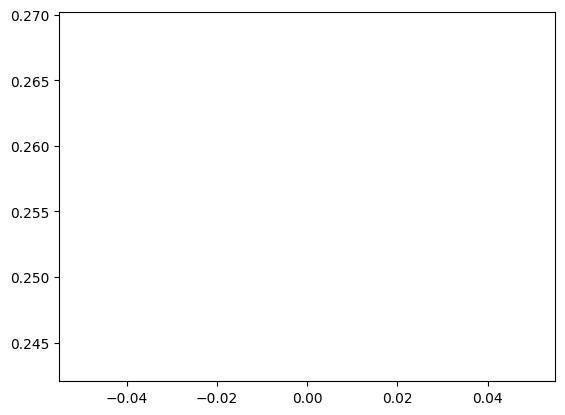

In [11]:
plt.plot(losses)
plt.show()

In [13]:
model.save('model_weights.pth')


In [26]:
from detecto.core import Model
model = Model.load('model_weights.pth', ['vehicle'])

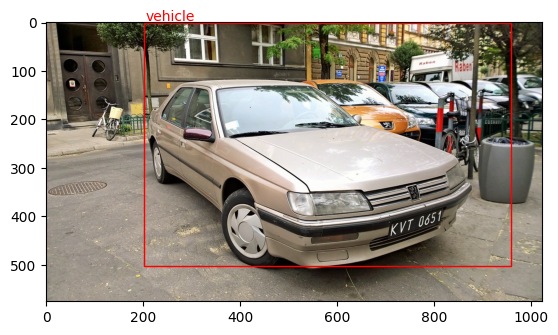

In [17]:
image = utils.read_image('/content/drive/MyDrive/train/00a7a72a499932f0d36d83c0e084fac3.jpg')
predictions = model.predict(image)
labels, boxes, scores = predictions
show_labeled_image(image, boxes, labels)

In [19]:
# check if notebook is in colab
try:
    import google.colab
    import subprocess
    import sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", "ezkl"])
    subprocess.check_call([sys.executable, "-m", "pip", "install", "onnx"])

# rely on local installation of ezkl if the notebook is not in colab
except:
    pass

import os
import json
import ezkl

In [20]:
# Specify all the files we need

model_path = os.path.join('network.onnx')
compiled_model_path = os.path.join('network.ezkl')
pk_path = os.path.join('test.pk')
vk_path = os.path.join('test.vk')
settings_path = os.path.join('settings.json')
srs_path = os.path.join('kzg.srs')
witness_path = os.path.join('witness.json')
data_path = os.path.join('input.json')

In [ ]:
model.load_state_dict(checkpoint['state_dict'])
### now you can evaluate it
model.eval()

In [29]:
import numpy as np
import torch
import torch.nn as nn

class Model(nn.Module):
    # define nn
    def __init__(self):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(4, 20)
        self.fc2 = nn.Linear(20, 20)
        self.fc3 = nn.Linear(20, 3)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.softmax(x)

        return x

# Initialize Model
model = Model()

In [30]:
# After training, export to onnx (network.onnx) and create a data file (input.json)

# create a random input
x = 0.1*torch.rand(*[1, 4], requires_grad=True)

# Flips the neural net into inference mode

model.eval()

# Export the model
torch.onnx.export(model,                     # model being run
                  x,                         # model input (or a tuple for multiple inputs)
                  model_path,                # where to save the model (can be a file or file-like object)
                  export_params=True,        # store the trained parameter weights inside the model file
                  opset_version=10,          # the ONNX version to export the model to
                  do_constant_folding=True,  # whether to execute constant folding for optimization
                  input_names = ['input'],   # the model's input names
                  output_names = ['output'], # the model's output names
                  dynamic_axes={'input' : {0 : 'batch_size'},    # variable length axes
                                'output' : {0 : 'batch_size'}})

data_array = ((x).detach().numpy()).reshape([-1]).tolist()

data = dict(input_data = [data_array])

    # Serialize data into file:
json.dump(data, open(data_path, 'w'))

============= Diagnostic Run torch.onnx.export version 2.0.1+cu118 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



In [31]:
!RUST_LOG=trace
# TODO: Dictionary outputs
res = ezkl.gen_settings(model_path, settings_path)
assert res == True

res = await ezkl.calibrate_settings(data_path, model_path, settings_path, "resources")  # Optimize for resources

In [32]:
res = ezkl.compile_model(model_path, compiled_model_path, settings_path)
assert res == True

In [33]:
res = ezkl.get_srs(srs_path, settings_path)

In [34]:
res = ezkl.setup(
        compiled_model_path,
        vk_path,
        pk_path,
        srs_path,
        settings_path,
    )

assert res == True
assert os.path.isfile(vk_path)
assert os.path.isfile(pk_path)
assert os.path.isfile(settings_path)

In [35]:
# Generate the Witness for the proof

# now generate the witness file
witness_path = os.path.join('witness.json')

res = ezkl.gen_witness(data_path, compiled_model_path, witness_path, settings_path = settings_path)
assert os.path.isfile(witness_path)

In [36]:
# Generate the proof

proof_path = os.path.join('proof.json')

proof = ezkl.prove(
        witness_path,
        compiled_model_path,
        pk_path,
        proof_path,
        srs_path,
        "evm",
        "single",
        settings_path,
    )

print(proof)
assert os.path.isfile(proof_path)

{'instances': [[[0, 0, 0, 0], [6425625360762666998, 7924344314350639699, 14762033076929465436, 2023505479389396574], [415066004289224689, 11886516471525959549, 3696305541684646538, 3035258219084094862], [12436184717236109307, 3962172157175319849, 7381016538464732718, 1011752739694698287]], [[9909020714504028113, 11418976574254634324, 2973276796214101733, 2131778123646343255], [5432626032756654017, 1961834588764195904, 11835134460333605139, 1680038075927467451], [5432626032756654017, 1961834588764195904, 11835134460333605139, 1680038075927467451]]], 'proof': '2af7b3754774e4c845d3e2962739292cc4f35d7dfb72ed2f854b5eaf88d3b3fb150257d9c6dc094ca600224147c229dcd8e2afd9819c286727757f75b8c73ec6005d45df2ff4331bdac9ce6f5ad894afec77ab0c9f205b8b963d7f0be81c62860b23bf1ca90374199a42555f2b69e161954d160cf51b377025a8712a1e106a622a1022c0a72b5fb4e0551891ea3d670c8afffa8125971aad5c838c22e303006a0020be1ba998c1d750cafe78ebf24a4174fe735447e8ced188ce9622e6480b422d8a27d81116e486012ef2b81fddd6e75773ea4a03abeb23dbf

In [37]:
# verify our proof

res = ezkl.verify(
        proof_path,
        settings_path,
        vk_path,
        srs_path,
    )

assert res == True
print("verified")

verified


In [38]:
# check if notebook is in colab
try:
    import google.colab
    import subprocess
    import sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", "solc-select"])
    !solc-select install 0.8.20
    !solc-select use 0.8.20
    !solc --version

# rely on local installation if the notebook is not in colab
except:
    pass

Installing solc '0.8.20'...
Version '0.8.20' installed.
Switched global version to 0.8.20
solc, the solidity compiler commandline interface
Version: 0.8.20+commit.a1b79de6.Linux.g++


In [39]:
    sol_code_path = os.path.join('Verifier.sol')
    abi_path = os.path.join('Verifier.abi')

    res = ezkl.create_evm_verifier(
        vk_path,
        srs_path,
        settings_path,
        sol_code_path,
        abi_path
    )

    assert res == True
    assert os.path.isfile(sol_code_path)

In [40]:
onchain_input_array = []

for value in proof["instances"]:
    for field_element in value:
        onchain_input_array.append(ezkl.vecu64_to_int(field_element))
# This will be the values you use onchain
# copy them over to remix and see if they verify
# What happens when you change a value?
print("pubInputs: ", onchain_input_array)
print("proof: ", "0x" + proof["proof"])

pubInputs:  [0, 2, 3, 1, 9, 12, 12]
proof:  0x2af7b3754774e4c845d3e2962739292cc4f35d7dfb72ed2f854b5eaf88d3b3fb150257d9c6dc094ca600224147c229dcd8e2afd9819c286727757f75b8c73ec6005d45df2ff4331bdac9ce6f5ad894afec77ab0c9f205b8b963d7f0be81c62860b23bf1ca90374199a42555f2b69e161954d160cf51b377025a8712a1e106a622a1022c0a72b5fb4e0551891ea3d670c8afffa8125971aad5c838c22e303006a0020be1ba998c1d750cafe78ebf24a4174fe735447e8ced188ce9622e6480b422d8a27d81116e486012ef2b81fddd6e75773ea4a03abeb23dbf975b6981dc35a1353d08c28499333ec7795b11e1eb1c9dd0c94ed3cade1a3e75a9403a157e2d2183d1d9824e11d3b0159376ce3898007f926e8952f49cc1ea93b0d6cfd1c15b61d4068f06416f393cc0778822febbbb91029a9d93134d7b94fcab37ffee90d9b2aa2637f06b4f56cb7a8efcf72e15dd7745de26edb5265a886acccbfd4a365eb1064d8ec1f8dbe67103bb9566ca13ea608ab06aa0ebe7d24ada2ddd53757dd492949bb31cf2cfcc9a8fca304fe454a4cbba3696cc1e2b8f3d439bcba96750219203ee416833e50ea043af9e369e1f7e27debfb4e9721a6f06613a23b55740838296921535634de2e0874ffc18b709c38df8761b4893613c68815ec98a9